# Problem Set 3 - Heston Simulation
Group 2  
10/30/22

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

plt.style.use('seaborn')

In [2]:
r = 0.02
κ = 0.1
θ = 0.04
η = 0.5
ρ = -0.6

S0 = 100
K = np.linspace(75, 125)

T = 1
m = 10000
n = 250
dt = T / n

## (a)

In [3]:
def calc_price_mc(S, K, r, T):
    """
    Calculate the European call price using Monte-Carlo simulation results
    """
    return np.exp(-r*T) * np.mean(np.maximum(S - K, 0))

### Euler Discretization

In [4]:
S = np.zeros((n+1, m))
V = np.zeros((n+1, m))

S[0] = S0
V[0] = θ

In [5]:
np.random.seed(42)

for i in range(1, n + 1):
    Z_V = np.random.standard_normal(m)
    Z_S = ρ * Z_V + np.sqrt(1 - ρ ** 2) * np.random.standard_normal(m)
    V[i] = V[i-1] + \
            κ * (θ - np.maximum(V[i-1], 0)) * dt + \
            η * np.sqrt(np.maximum(V[i-1], 0)) * Z_V * np.sqrt(dt)
    S[i] = S[i-1] * \
            np.exp((r - np.maximum(V[i-1], 0) / 2) * dt + \
                   np.sqrt(np.maximum(V[i-1], 0)) * Z_S * np.sqrt(dt))

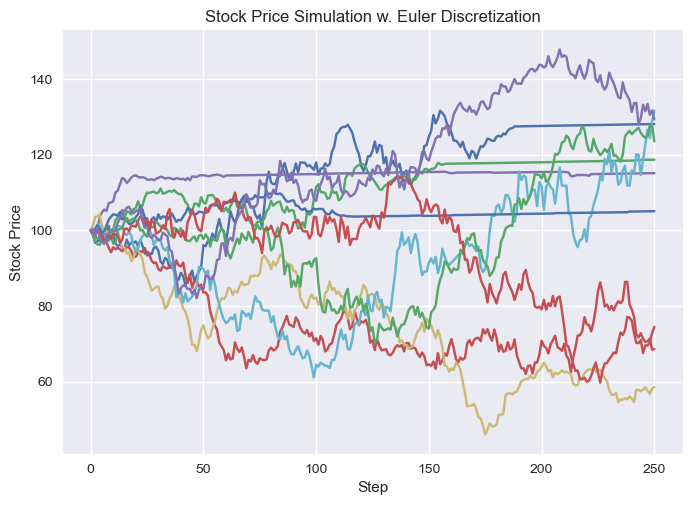

In [6]:
plt.plot(S[:, :10])
plt.xlabel('Step')
plt.ylabel('Stock Price')
plt.title('Stock Price Simulation w. Euler Discretization')
plt.show()

In [7]:
C_heston_euler = np.zeros(len(K))
for i, v in enumerate(K):
    C_heston_euler[i] = calc_price_mc(S[-1, :], v, r, T)

### QE Method

In [8]:
S = np.zeros((n+1, m))
V = np.zeros((n+1, m))

S[0] = S0
V[0] = θ

In [9]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")

np.random.seed(42)

Ψ_c = 1.5
γ_1 = 0.5
γ_2 = 0.5
K_0 = -ρ * κ * θ / η * dt
K_1 = γ_1 * dt * (κ * ρ / η - 0.5) - ρ / η
K_2 = γ_2 * dt * (κ * ρ / η - 0.5) + ρ / η
K_3 = γ_1 * dt * (1 - ρ ** 2)
K_4 = γ_2 * dt * (1 - ρ ** 2)


def psi_inv(u, p, β):
    return np.where(u <= p, 0, np.log((1-p)/(1-u))/β)


for i in range(1, n + 1):
    M = θ + (V[i-1] - θ) * np.exp(-κ*dt)
    ss = V[i-1] * η ** 2 * np.exp(-κ*dt) / κ * (1 - np.exp(-κ*dt)) + \
            θ * η ** 2 / κ / 2 * (1 - np.exp(-κ*dt)) ** 2
    Ψ = ss / (M ** 2)
    
    # update volatility
    U_V = np.random.uniform(size=m)
    # when Ψ <= Ψ_c
    b = np.sqrt(2/Ψ - 1 + np.sqrt(2/Ψ) * np.sqrt(2/Ψ - 1))
    a = M / (1 + b ** 2)
    Z_V = norm.ppf(U_V)
    V_new_1 = a * (b + Z_V) ** 2
    # when Ψ > Ψ_c
    p = (Ψ - 1) / (Ψ + 1)
    β = (1 - p) / M
    V_new_2 = psi_inv(U_V, p, β)
    
    V[i] = np.where(Ψ <= Ψ_c, V_new_1, V_new_2)
    
    # update stock price
    U_S = np.random.uniform(size=m)
    Z_S = norm.ppf(U_S)
    S[i] = S[i-1] * \
            np.exp(r * dt + \
                   K_0 + K_1 * V[i-1] + \
                   K_2 * V[i] + np.sqrt(K_3 * V[i-1] + K_4 * V[i]) * Z_S)

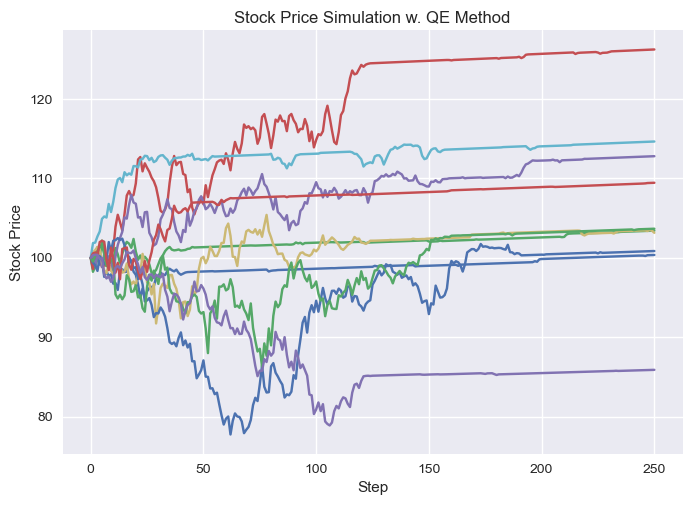

In [10]:
plt.plot(S[:, :10])
plt.xlabel('Step')
plt.ylabel('Stock Price')
plt.title('Stock Price Simulation w. QE Method')
plt.show()

In [11]:
C_heston_qe = np.zeros(len(K))
for i, v in enumerate(K):
    C_heston_qe[i] = calc_price_mc(S[-1, :], v, r, T)

### Euler vs. QE

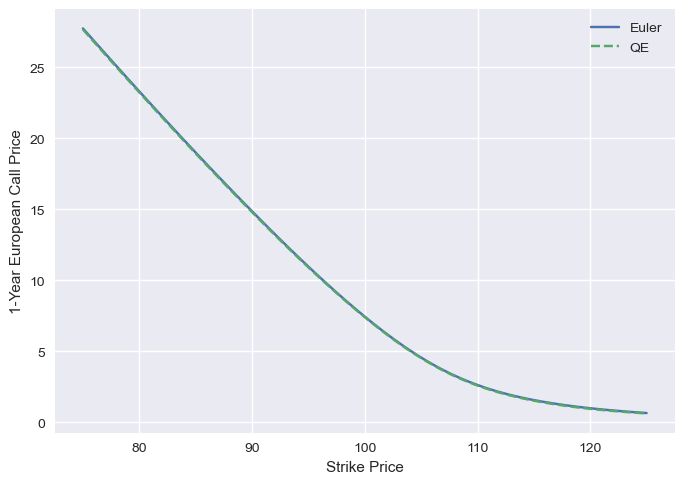

In [12]:
plt.plot(K, C_heston_euler)
plt.plot(K, C_heston_qe, '--')
plt.xlabel('Strike Price')
plt.ylabel('1-Year European Call Price')
plt.legend(['Euler', 'QE'])
plt.show()

## (b)

In [13]:
def calc_price_bsm(S, K, T, r, σ):
    """
    Calculate the European call price using the Black-Scholes-Merton model
    """
    d_1 = (np.log(S/K) + (r + σ ** 2 / 2) * T) / (σ * np.sqrt(T))
    d_2 = d_1 - σ * np.sqrt(T)
    
    return S * norm.cdf(d_1) - np.exp(-r*T) * K * norm.cdf(d_2)


def calc_vega_bsm(S, K, T, r, σ):
    """
    Calculate price sensitivity to volatility using the BSM model
    """
    d_1 = (np.log(S/K) + (r + σ ** 2 / 2) * T) / (σ * np.sqrt(T))
    
    return S * norm.pdf(d_1) * np.sqrt(T)


def calc_implied_vol_bsm(C, S, K, T, r):
    """
    Calculate implied volatility using Newton method
    """
    max_itr = 1000
    precision = 1e-6
    σ = np.sqrt(θ)
    for i in range(0, max_itr):
        price = calc_price_bsm(S, K, T, r, σ)
        vega = calc_vega_bsm(S, K, T, r, σ)
        diff = C - price
        if (abs(diff) < precision):
            return σ
        σ = σ + diff / vega
    return σ

In [14]:
V_imp_euler = np.zeros(len(K))
for i, v in enumerate(K):
    V_imp_euler[i] = calc_implied_vol_bsm(C_heston_euler[i], S0, K[i], T, r)

In [15]:
V_imp_qe = np.zeros(len(K))
for i, v in enumerate(K):
    V_imp_qe[i] = calc_implied_vol_bsm(C_heston_qe[i], S0, K[i], T, r)

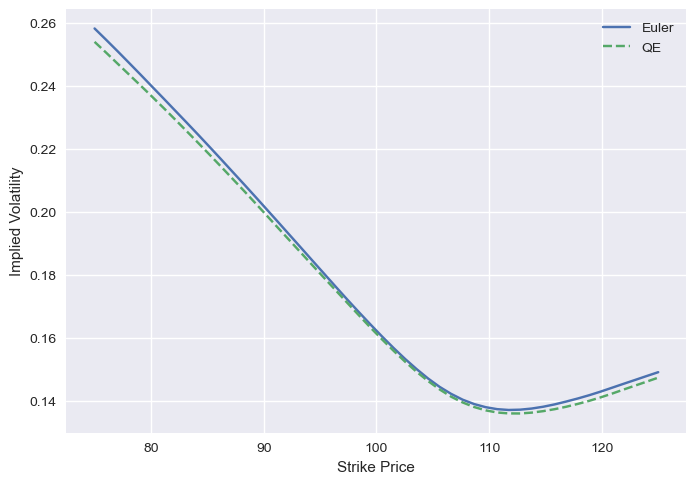

In [16]:
plt.plot(K, V_imp_euler)
plt.plot(K, V_imp_qe, '--')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend(['Euler', 'QE'])
plt.show()

## (c)

In [17]:
C_bsm = np.zeros(len(K))
for i, v in enumerate(K):
    C_bsm[i] = calc_price_bsm(S0, v, T, r, np.sqrt(θ))

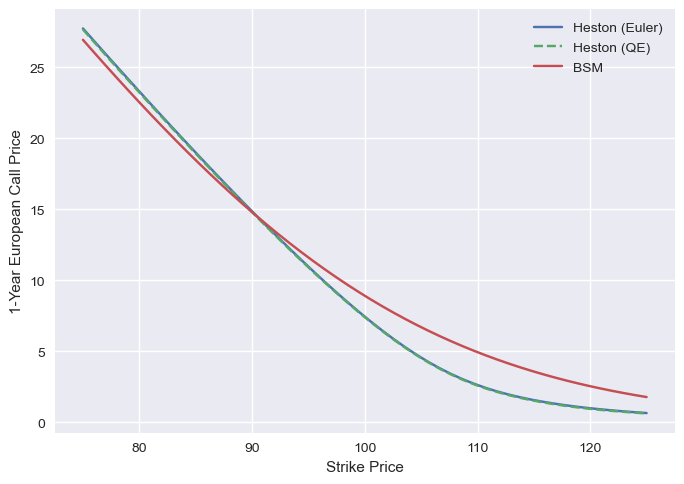

In [18]:
plt.plot(K, C_heston_euler)
plt.plot(K, C_heston_qe, '--')
plt.plot(K, C_bsm)
plt.xlabel('Strike Price')
plt.ylabel('1-Year European Call Price')
plt.legend(['Heston (Euler)', 'Heston (QE)', 'BSM'])
plt.show()